In [1]:
import glob
import uproot
import pandas as pd
import numpy as np
import awkward as ak
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Normalization
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import utils.tools as tools
import utils.plotting as plotting

import mplhep as cms
import matplotlib.pyplot as plt

cms.style.use("CMS")
plt.rcParams["figure.figsize"] = (7,7)

2024-07-03 15:13:55.968532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 15:13:59.156924: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 15:14:00.213119: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/grid.cern.ch/centos7-umd4-ui-4.0.3-1_191004/lib64:/cvmfs/grid.cern.ch/centos7-umd4-ui-4.0

In [2]:
# flags
useEmu = False
useMP = False # bugfix MP MET
useEmu = True if useMP else useEmu
makePlots = True
keepStruct = False
flatSample = False

doFixedRate = True

# NN stuff
# fraction of signal to train on vs check performance
testNN = False
trainNN = True
trainFrac = 0.5
useGPU = False
normLayer = True
scaleData = False

device = 'GPU: 0' if useGPU else 'CPU: 0'

# objects to use in the training
nObj = 4

# L1 threshold to use for efficiencies
l1MetThresh = 50
netMET_thresh = l1MetThresh

# offline threshold to cut rate check to save time
# *** this is not safe for fixed rate efficiency plots!
l1METCutForRate = 0

# filter out all events with puppiMET < this value
puppiMETCut = 0

# define input sums (case sensitive, see branches.py)
inputSums = ['methf', 'ntt']

# define input objects [Jet, EG, Tau] (case sensitive)
inputs = ['Jet']

# files 
# ** Remember to change inputFormat to nano with new files
#sigFiles = "/Volumes/home/netmet_zmuD_full/303.root" #"../data/zmuD/zmuD_*.root"
#bkgFiles = "/Volumes/home/netmet_zbD_full/303.root" #"../data/zbD/zbD_4.root"

# small test files
#sigFiles = "../data/zmuD_1k.root"
#bkgFiles = "../data/zbD_303.root"

# 2023D nanoAOD on EOS
#sigFiles = "/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/bundocka/netMET/nano/zmuD/*.root"
#bkgFiles = "/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/bundocka/netMET/nano/zbD/*.root"
sigFiles = ["root://eoscms.cern.ch://store/group/dpg_trigger/comm_trigger/L1Trigger/bundocka/Muon0/zmu24E_NetMET/240628_140553/0000/nano_1.root"]
bkgFiles = ["root://eoscms.cern.ch://store/group/dpg_trigger/comm_trigger/L1Trigger/bundocka/ZeroBias/zb24E_NetMET/240628_140446/0000/nano_1.root"]
#sigFiles = ["/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/bundocka/Muon0/zmu24E_NetMET/240628_140553/0000/nano_1.root"]
#bkgFiles = ["/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/bundocka/ZeroBias/zb24E_NetMET/240628_140446/0000/nano_1.root"]


inputFormat = 'nano'     # nanoAOD
#inputFormat = 'parquet'  # awkward arrays
#inputFormat = 'hdf5'     # pandas dataframes

awkSigFile = "data/sig.parquet"
awkBkgFile = "data/bkg.parquet"

dfSigFile = "data/sig_df.hdf5"
dfBkgFile = "data/bkg_df.hdf5"

modelFile = "models/netMET.keras"

In [3]:
if inputFormat == 'nano':
    
    # get the branches to retrieve from nanoAOD
    branches = tools.getBranches(inputs, useEmu, useMP)

    # input files
    try:
        sig = glob.glob(sigFiles)
        bkg = glob.glob(bkgFiles)
    except TypeError:
        sig = sigFiles
        bkg = bkgFiles
    
    sig_data = tools.getArrays(sig, branches, len(sig), awkSigFile)
    bkg_data = tools.getArrays(bkg, branches, len(bkg), awkBkgFile)
    

if inputFormat == 'parquet':
        
    sig_data = ak.from_parquet(awkSigFile)    
    bkg_data = ak.from_parquet(awkBkgFile)

['root://eoscms.cern.ch://store/group/dpg_trigger/comm_trigger/L1Trigger/bundocka/Muon0/zmu24E_NetMET/240628_140553/0000/nano_1.root']


In [4]:
if inputFormat in ['nano', 'parquet']:

    # get the puppiMETs
    puppiMET, puppiMET_noMu = tools.getPUPPIMET(sig_data)
    puppiMET_noMu_unfilt = ak.copy(puppiMET_noMu)

    # get unfiltered l1MET
    l1METUnfilt = tools.getSum(sig_data, 'methf')

    # pick events to flatten the MET distribution
    if flatSample:
        sig_data, puppiMET_noMu = tools.flatten(sig_data, puppiMET_noMu, ['puppi', 'l1'])

    # prepare collections
    collections_sig = tools.getCollections(sig_data, inputSums, inputs)
    collections_bkg = tools.getCollections(bkg_data, inputSums, inputs)
    
    # cut background events with low MET to save time with inference
    for col in collections_bkg:
        methf = ak.flatten(collections_bkg['methf']['EtSum_pt'])
        collections_bkg[col] = collections_bkg[col][methf > l1METCutForRate]

    # make dataframes
    sig_df = tools.makeDataframe(collections_sig, dfSigFile, nObj, keepStruct)
    bkg_df = tools.makeDataframe(collections_bkg, dfBkgFile, nObj, keepStruct)
    
    # keep non flattened l1MET for MET comparisons
    l1METUnfilt_df = tools.arrayToDataframe(l1METUnfilt['EtSum_pt'], 'l1MET_unfilt', dfSigFile)

    # make PUPPI dataframes
    puppiMET_df = tools.arrayToDataframe(puppiMET, 'puppiMET', dfSigFile)
    puppiMETNoMu_df = tools.arrayToDataframe(puppiMET_noMu, 'puppiMET_noMu', dfSigFile)
    puppiMETNoMuUnfilt_df = tools.arrayToDataframe(puppiMET_noMu_unfilt, 'puppiMET_noMu_unfilt', dfSigFile)
    nPVs_df = pd.DataFrame(ak.to_list(sig_data["PV_npvsGood"]))
    nPVs_df.to_hdf(dfSigFile, 'nPVs', mode='a')
    
    # filter out events with large/saturated L1 MET from signal for training
    puppiMETNoMu_df = puppiMETNoMu_df[sig_df['methf_0_pt'] < 1000]
    nPVs_df = nPVs_df[sig_df['methf_0_pt'] < 1000]
    sig_df = sig_df[sig_df['methf_0_pt'] < 1000]


/home/hep/jleonhol/netmet_jup/netMET/utils/tools.py:159: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf(fileName, 'online', mode='w')
/home/hep/jleonhol/netmet_jup/netMET/utils/tools.py:159: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf(fileName, 'online', mode='w')
/home/hep/jleonhol/netmet_jup/netMET/utils/tools.py:167: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf(fileName, label, mode='a')
/tmp/ipykernel_3503440/1748268025.py:35: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  nPVs_df.to_hdf(dfSigFile, 'nPVs', mode='a')


In [5]:
if inputFormat == 'hdf5':
    
    sig_df = pd.read_hdf(dfSigFile, 'online')
    bkg_df = pd.read_hdf(dfBkgFile, 'online')
    puppiMET_df = pd.read_hdf(dfSigFile, 'puppiMET')
    puppiMETNoMu_df = pd.read_hdf(dfSigFile, 'puppiMET_noMu')
    puppiMETNoMuUnfilt_df = pd.read_hdf(dfSigFile, 'puppiMET_noMu_unfilt')
    l1METUnfilt_df = pd.read_hdf(dfSigFile, 'l1MET_unfilt')
    nPVs_df = pd.read_hdf(dfSigFile, 'nPVs')

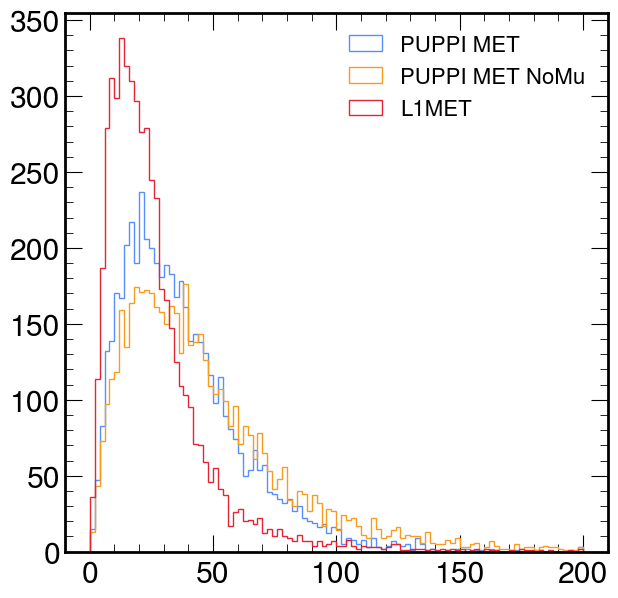

In [6]:
# plot the MET distributions
l1MET = sig_df['methf_0_pt']

if makePlots:
    plt.hist(puppiMET_df['PuppiMET_pt'], bins = 100, range = [0,200], histtype = 'step', log = False, label = "PUPPI MET")
    plt.hist(puppiMETNoMu_df['PuppiMET_pt'], bins = 100, range = [0,200], histtype = 'step',  label = "PUPPI MET NoMu")
    plt.hist(l1MET, bins = 100, range = [0,200], histtype = 'step', label = "L1MET")
    if flatSample:
      plt.hist(puppiMETNoMuUnfilt_df['PuppiMET_pt'], bins = 100, range = [0,200], histtype = 'step', label = "PUPPI MET NoMu unfiltered")
      plt.hist(l1METUnfilt_df, bins = 100, range = [0,200], histtype = 'step', label = "L1MET unfiltered")

plt.legend(fontsize=16)

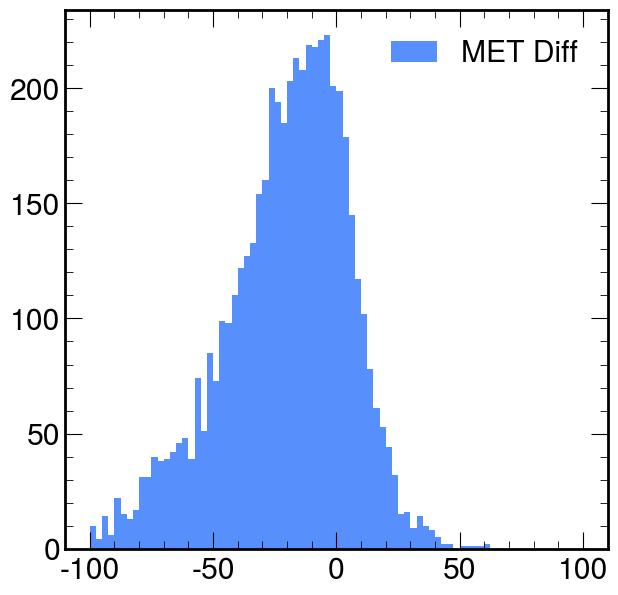

In [7]:
# plot the MET resolution
if makePlots:
    plt.hist((l1MET - puppiMETNoMu_df['PuppiMET_pt']), bins = 80, range = [-100,100], label = "MET Diff")
    plt.legend()

/home/hep/jleonhol/netmet_jup/envs/netMET/lib64/python3.9/site-packages/awkward/_nplikes/array_module.py:246: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


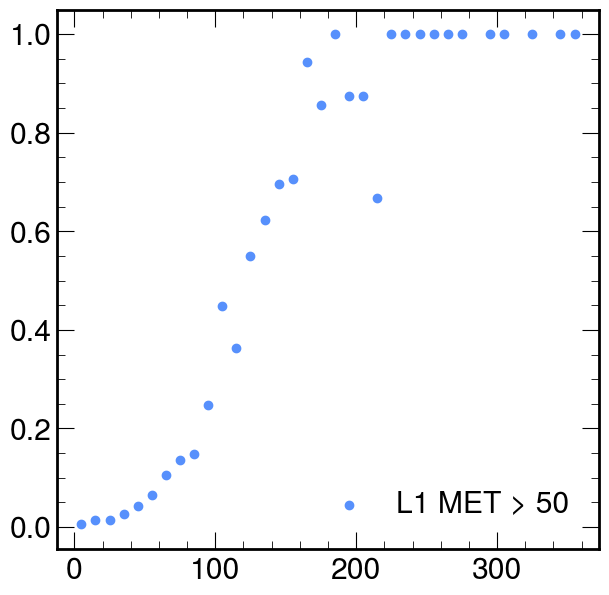

In [8]:
# plot the MET efficiency 
eff_data, xvals = plotting.efficiency(l1MET, puppiMETNoMu_df['PuppiMET_pt'], l1MetThresh, 10, 400)

if makePlots:
    plt.scatter(xvals, eff_data, label="L1 MET > " + str(l1MetThresh))
    plt.legend()

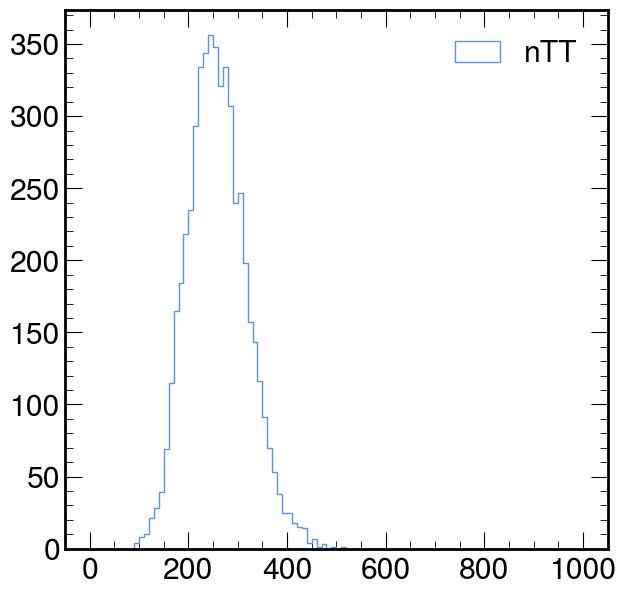

In [9]:
# get the nTT
if 'ntt' in inputSums:
    l1nTT = sig_df['ntt_0_pt']

    if makePlots and l1nTT.any() > 0:
        plt.hist(l1nTT, bins = 100, range = [0,1000], histtype = 'step', label = 'nTT')
        plt.legend()

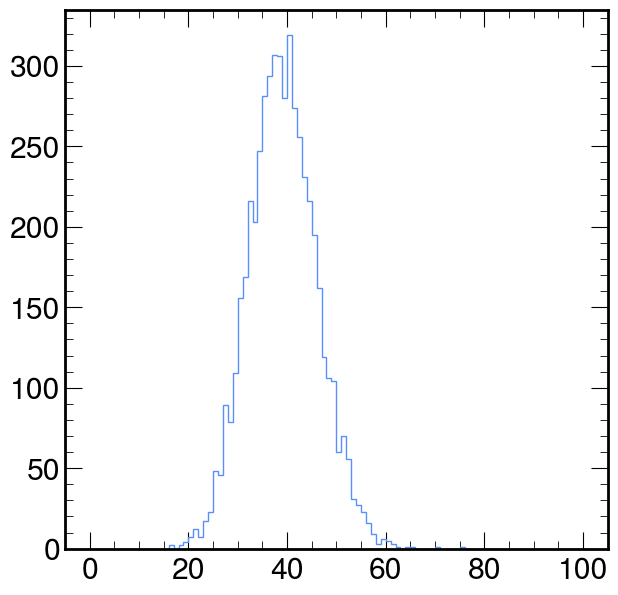

In [10]:
if makePlots:
    plt.hist(nPVs_df, bins = 100, range = [0,100], histtype = 'step', label = 'nPVsGood')

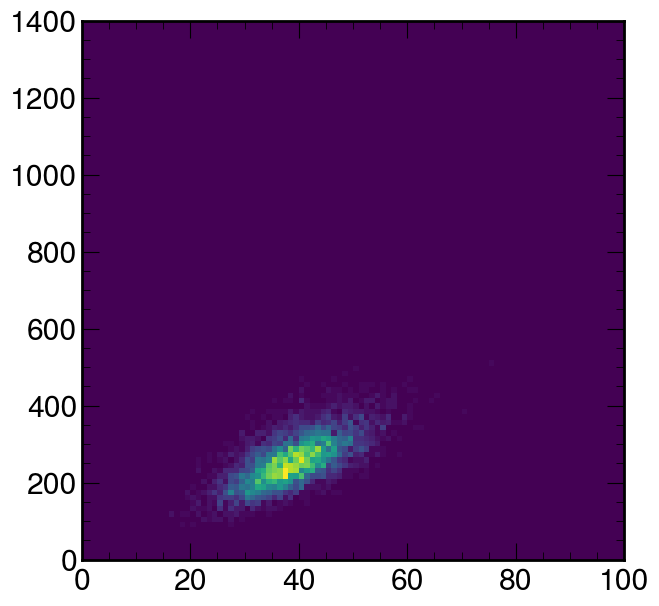

In [11]:
# plot the nTT vs reco nVtx
if 'ntt' in inputSums:
    if makePlots and l1nTT.any() > 0:
        plt.hist2d(nPVs_df.to_numpy().flatten(), ak.to_numpy(l1nTT), bins=[100, 100], range=[[0,100],[0,1400]])

In [12]:
sig_df

,Jet_0_eta,Jet_0_phi,Jet_0_pt,Jet_1_eta,Jet_1_phi,Jet_1_pt,Jet_2_eta,Jet_2_phi,Jet_2_pt,Jet_3_eta,Jet_3_phi,Jet_3_pt,methf_0_pt,ntt_0_pt
0,1.609619,2.218262,65.0,1.087402,0.043503,25.5,-1.696533,-0.584717,24.0,-3.566895,-2.498535,17.0,26.5,281.0
1,3.741211,2.044434,56.0,2.262207,1.435547,41.5,1.609619,0.913452,23.0,0.652466,0.913452,17.0,27.5,259.5
2,3.219238,2.305664,58.0,2.392578,0.478516,34.0,0.826538,-1.454590,29.0,0.217499,-1.889648,26.5,21.0,435.5
3,-0.217499,3.001465,27.0,-1.435547,-0.671631,23.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,2.0,151.0
4,1.609619,2.479492,40.5,1.087402,-0.845703,27.0,0.391479,-1.367676,25.5,-1.261475,-2.672852,18.0,17.5,293.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,4.262695,3.088379,52.0,2.087891,1.870605,35.0,1.609619,-0.584717,33.5,1.174561,-1.628662,23.0,22.5,315.0
5219,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,21.5,155.5
5220,-2.392578,0.130493,15.5,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,6.0,171.5
5221,2.392578,2.566406,30.0,1.435547,1.522461,25.0,0.739502,1.174561,23.0,0.391479,0.913452,20.5,30.0,355.5


In [13]:
puppiMETNoMu_df

,PuppiMET_pt
0,48.759895
1,104.013786
2,59.436253
3,10.841270
4,62.679337
...,...
5218,15.727248
5219,15.913570
5220,33.423752
5221,73.414452


In [14]:
X = sig_df.copy()
Y = puppiMETNoMu_df.copy()
scaler = StandardScaler()

if scaleData:
	X[X.columns] = pd.DataFrame(scaler.fit_transform(X))

X_train = X.sample(frac=trainFrac, random_state=3).dropna()
Y_train = Y.loc[X_train.index]

print(X_train[:10])
print(Y_train[:10])

# define baseline model
def baseline_model(nInput):
	# create model
	model = Sequential()
	# normalize layers
	if normLayer:
		normalizer = tf.keras.layers.Normalization(input_shape=[nInput,], axis=-1)
		normalizer.adapt(X_train)
		model.add(normalizer)
	model.add(Dense(nInput*32, input_shape=(nInput,), activation='relu'))
	model.add(Dense(nInput*32, activation='relu'))
	model.add(Dense(1))
	# Compile model
	model.compile(loss='mean_absolute_percentage_error',  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
	#model.compile(loss='huber_loss', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
	return model


      Jet_0_eta  Jet_0_phi  Jet_0_pt  Jet_1_eta  Jet_1_phi  Jet_1_pt  \
3978   0.913452   1.609619      62.0   0.130493   1.174561      21.0   
874    0.391479  -1.715576      16.0   0.000000   0.000000       0.0   
3314  -1.000488   2.479492      49.5  -1.261475   0.217499      25.5   
1539   0.826538   2.392578      24.0  -1.348389   2.131348      17.0   
3664   0.739502   2.218262      30.0   0.130493  -0.410706      17.0   
3476   1.522461   2.740723      29.5  -3.741211  -0.932739      10.5   
4378   1.174561   1.348389      30.0   0.217499   0.304504      29.5   
1950  -1.522461   2.044434      90.5  -1.522461  -0.149689      18.5   
2704   1.609619   2.827637      18.5  -1.348389  -1.106689      15.0   
1647   3.741211   0.913452      27.5   1.261475  -1.454590      25.0   

      Jet_2_eta  Jet_2_phi  Jet_2_pt  Jet_3_eta  Jet_3_phi  Jet_3_pt  \
3978   0.130493  -2.411621      18.0  -1.000488  -2.585449      17.0   
874    0.000000   0.000000       0.0   0.000000   0.000000     

In [15]:
# evaluate model with standardized dataset
if testNN:
	with tf.device(device):
		estimators = []
		estimators.append(('standardize', StandardScaler()))
		estimators.append(('mlp', KerasRegressor(model=baseline_model, epochs=10, batch_size=500, verbose=1)))
		pipeline = Pipeline(estimators)
		kfold = KFold(n_splits=5)
		results = cross_val_score(pipeline, X_train, Y, cv=kfold, scoring='neg_mean_squared_error')
		print("Standardized results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [16]:
# train final model
if trainNN:
    with tf.device(device):
        model = baseline_model(X_train.shape[1])
        model.fit(X_train, Y_train, epochs=10, batch_size=500, verbose=1)
        model.save(modelFile)

2024-07-03 15:15:25.695988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/grid.cern.ch/centos7-umd4-ui-4.0.3-1_191004/lib64:/cvmfs/grid.cern.ch/centos7-umd4-ui-4.0.3-1_191004/lib:/cvmfs/grid.cern.ch/centos7-umd4-ui-4.0.3-1_191004/usr/lib64:/cvmfs/grid.cern.ch/centos7-umd4-ui-4.0.3-1_191004/usr/lib
2024-07-03 15:15:25.712099: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-03 15:15:25.712190: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lx04.hep.ph.ic.ac.uk): /proc/driver/nvidia/version does not exist
2024-07-03 15:15:25.787739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU ins

Epoch 1/10
6/6 [==============================] - 2s 8ms/step - loss: 81.8089
Epoch 2/10
6/6 [==============================] - 0s 7ms/step - loss: 62.0970
Epoch 3/10
6/6 [==============================] - 0s 8ms/step - loss: 59.1005
Epoch 4/10
6/6 [==============================] - 0s 7ms/step - loss: 58.6325
Epoch 5/10
6/6 [==============================] - 0s 6ms/step - loss: 56.7506
Epoch 6/10
6/6 [==============================] - 0s 7ms/step - loss: 56.6069
Epoch 7/10
6/6 [==============================] - 0s 6ms/step - loss: 55.8270
Epoch 8/10
6/6 [==============================] - 0s 7ms/step - loss: 55.7423
Epoch 9/10
6/6 [==============================] - 0s 7ms/step - loss: 55.4136
Epoch 10/10
6/6 [==============================] - 0s 6ms/step - loss: 55.3215


In [17]:
# predict values for efficiency
Xp = X.drop(X_train.index)
      
with tf.device(device):
    model = keras.models.load_model(modelFile)
    Yp = model.predict(Xp)

82/82 [==============================] - 0s 1ms/step


In [18]:
Yp

array([[27.905802],
       [36.00067 ],
       [28.151403],
       ...,
       [13.300165],
       [10.987497],
       [12.182955]], dtype=float32)

In [19]:
# and for the rate
if doFixedRate:
    Xp_bkg = bkg_df.copy()

    if scaleData:
        Xp_bkg[Xp_bkg.columns] = pd.DataFrame(scaler.transform(Xp_bkg))

    with tf.device(device):    
        model = keras.models.load_model(modelFile)
        Yp_bkg = model.predict(Xp_bkg)

2709/2709 [==============================] - 3s 1ms/step


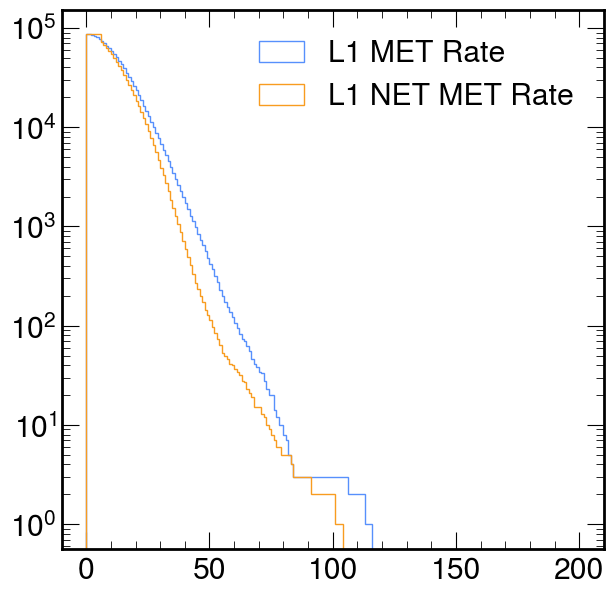

In [20]:
if doFixedRate:
    l1NetMET_bkg = Yp_bkg.flatten()
    l1MET_bkg = bkg_df['methf_0_pt']

    # rate plots must be in bins of GeV
    xrange = [0,200]
    bins = xrange[1]

    rateHist = plt.hist(l1MET_bkg, bins = bins, range = xrange, histtype = 'step', label = 'L1 MET Rate', cumulative=-1, log=True)
    rateHist_netMET = plt.hist(l1NetMET_bkg, bins = bins, range = xrange, histtype = 'step', label = 'L1 NET MET Rate', cumulative=-1, log=True)
    plt.legend()
        
    # get rate at threshold 
    l1MET_fixed_rate = rateHist[0][l1MetThresh*int((xrange[1]/bins))]
    netMET_thresh = plotting.getThreshForRate(rateHist_netMET[0], bins, l1MET_fixed_rate)

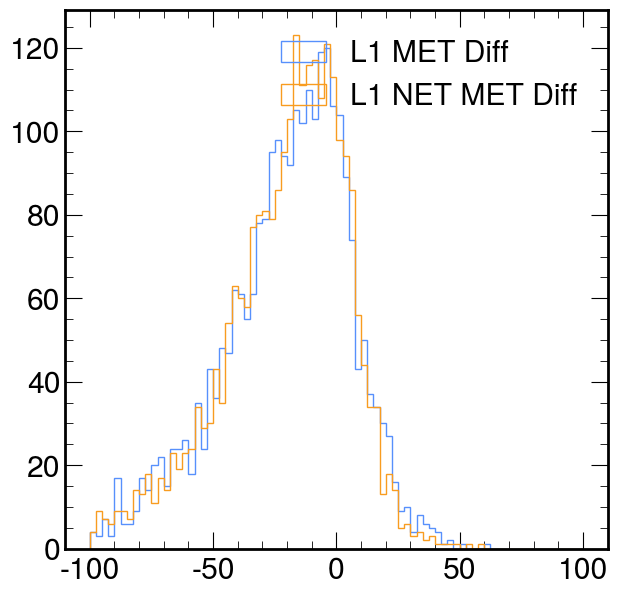

In [21]:
l1NetMET = Yp.flatten()
l1MET_test = l1MET.drop(X_train.index)
puppiMETNoMu_df_test = puppiMETNoMu_df.drop(X_train.index)

# plot the MET resolution
if makePlots:
    plt.hist((l1MET_test - puppiMETNoMu_df_test['PuppiMET_pt']), bins = 80, range = [-100,100], label = "L1 MET Diff", histtype = 'step')
    plt.hist((l1NetMET - puppiMETNoMu_df_test['PuppiMET_pt']), bins = 80, range = [-100,100], label = "L1 NET MET Diff", histtype = 'step')
    plt.legend()

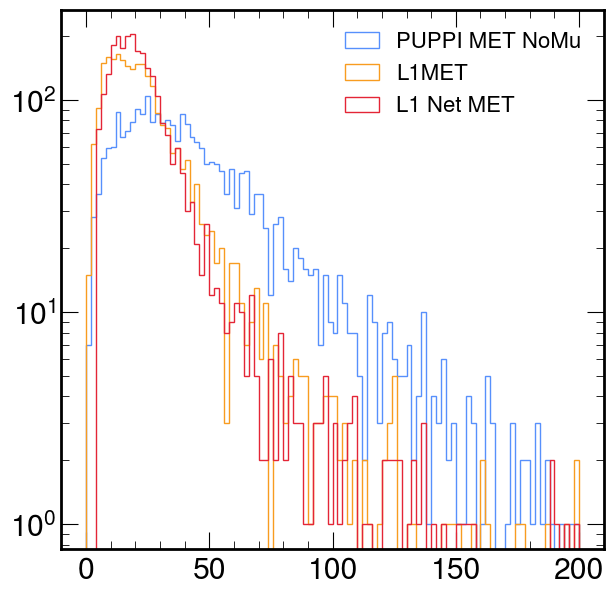

In [22]:
# plot the MET distributions
if makePlots:
    plt.hist(puppiMETNoMu_df_test['PuppiMET_pt'], bins = 100, range = [0,200], histtype = 'step',  log = True, label = "PUPPI MET NoMu")
    plt.hist(l1MET_test, bins = 100, range = [0,200], histtype = 'step', label = "L1MET")
    plt.hist(l1NetMET, bins = 100, range = [0,200], histtype = 'step', label = "L1 Net MET ")  
    plt.legend(fontsize=16)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [11., 49., 47., ...,  0.,  0.,  0.],
        [27., 48., 77., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 <matplotlib.collec

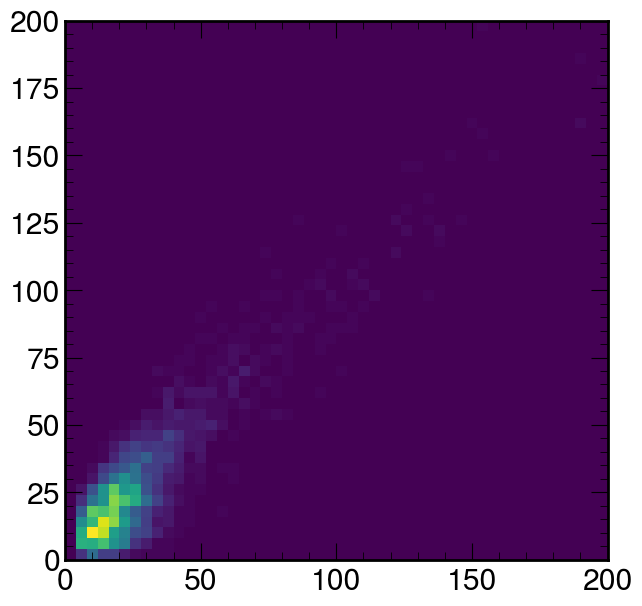

In [23]:
plt.hist2d(ak.to_numpy(ak.flatten(Yp)), l1MET_test, bins=[50, 50], range=[[puppiMETCut,200+puppiMETCut],[puppiMETCut,200+puppiMETCut]])

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 9., 12., 13., ...,  0.,  0.,  0.],
        [ 8., 16., 23., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 <matplotlib.collec

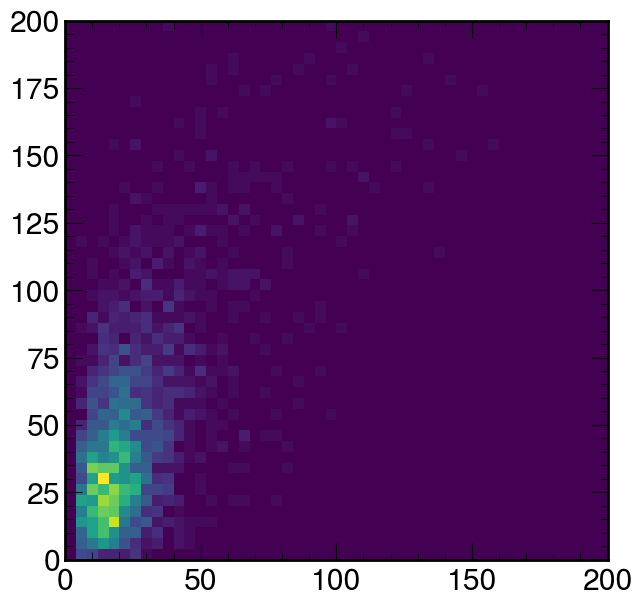

In [24]:
plt.hist2d(ak.to_numpy(ak.flatten(Yp)), ak.to_numpy(puppiMETNoMu_df_test['PuppiMET_pt']), bins=[50, 50], range=[[puppiMETCut,200+puppiMETCut],[puppiMETCut,200+puppiMETCut]])

(array([[ 1.,  1.,  9., ...,  0.,  0.,  0.],
        [ 5., 13., 15., ...,  0.,  0.,  0.],
        [ 9., 20., 18., ...,  0.,  0.,  1.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 <matplotlib.collec

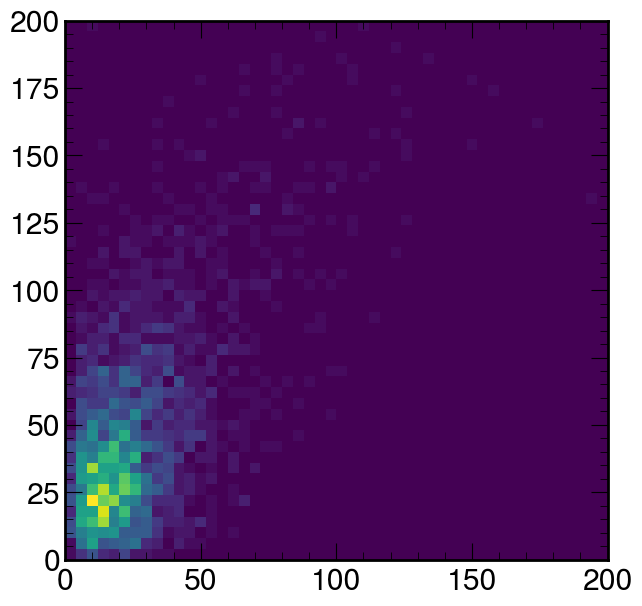

In [25]:
plt.hist2d(l1MET_test, ak.to_numpy(puppiMETNoMu_df_test['PuppiMET_pt']), bins=[50, 50], range=[[puppiMETCut,200+puppiMETCut],[puppiMETCut,200+puppiMETCut]])

/home/hep/jleonhol/netmet_jup/envs/netMET/lib64/python3.9/site-packages/awkward/_nplikes/array_module.py:246: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


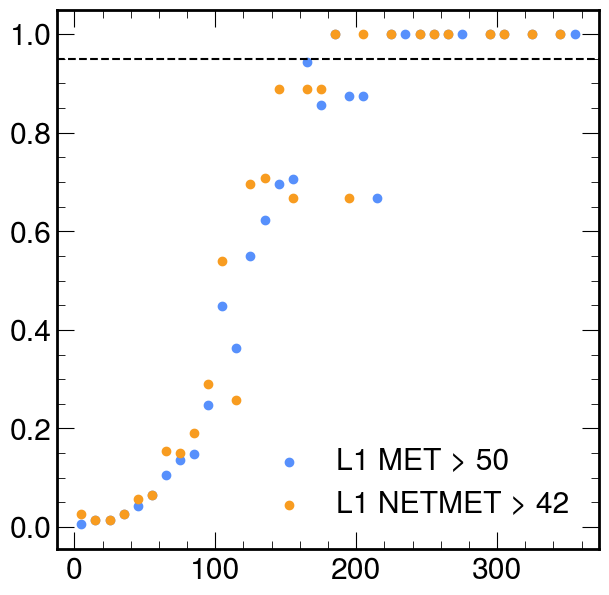

In [26]:
# plot the MET efficiency
eff_data, xvals = plotting.efficiency(l1MET, puppiMETNoMu_df['PuppiMET_pt'], l1MetThresh, 10, 400)
netMET_eff_data = plotting.efficiency(l1NetMET, puppiMETNoMu_df_test['PuppiMET_pt'], netMET_thresh, 10, 400)[0]

if makePlots:
    plt.axhline(0.95, linestyle='--', color='black')
    plt.scatter(xvals, eff_data, label="L1 MET > " + str(l1MetThresh))
    plt.scatter(xvals, netMET_eff_data, label="L1 NETMET > " + str(netMET_thresh))
    plt.legend()